# Solving the Infinite Symmetric Well using the Shooting Method
### Erik S. Sorensen, Physics & Astronomy, McMaster University, 21 September 2019
#### Last Edit: Pat Clancy - 25 September 2023

### Introduction

In this notebook we will be solving the infinite symmetric well using what is called the shooting method. The potential does not need to be a square well to use this method, but it is important that it is *symmetric*. To make the potential symmetric we will define $V(x)$ from $-a$ to $a$ rather than from $0$ to $a$ (as used for the infinite square well in Section 2.2 of Griffiths). Furthermore, we shall use units where $\hbar^2/m=1$.

Let's begin by importing some things we'll need: 

In [1]:
from pylab import *
from scipy.integrate import odeint #A differential equation solver
from scipy.optimize import brentq #A root finding algorithm
import matplotlib.pyplot as plt
import numpy as np #An immensely useful library for manipulating arrays and lists (i.e matrices and vectors)

The infinite square well is defined by the potential, which is $V(x)=0$ if $-a<x<a$ and $V(x)=\infty$ otherwise. Unfortunately for the computer, $\infty$ is not a real number and it has no concept of something infinite. Fortunately for us, we can get good results by just using some big number instead of actually using $\infty$. Take a second to consider what constitutes a number that is "big enough" to be a substitute for $\infty$ in this context. 

__ACTION__: Using the template below write a function
__V(x)__ which takes a variable __x__ and returns the potential at that coordinate.

In [88]:
def V(x):
    global a #Using global means we can set 'a' later in our code and V(x) will be aware of it.
    if -a < x < -a/2:
        return 0

    elif -a/2 < x < a/2:
        return -2

    elif a/2 < x < a:
        return 0

    else:
        return 1e10

Once we have a suitable potential function, what else do we need the computer to know in order to solve for $E_n$'s and their associated $\psi_n$'s? Well it definitely needs to know about the Schrodinger Equation, which really just describes the relationship between some function $\psi(x)$ and its derivatives. Specifically, it says (in our units) that $\psi''(x)=2[V(x)-E]\psi(x)$.

We want to use scipy's odeint differential equation solver to solve for $\psi(x)$. But odeint solves differential equations of the form $\frac{df}{dx}=g(x)$ (For more details, check out the documentation of odeint at https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

This means we want to rewrite the Schrodinger Equation as 2 first order coupled differential equations, which concern the first and second order derivatives of $\psi$.

Computationally then, we require a function that returns an array with 2 values, D1 and D2, that are the first and second derivatives at that value of $x$: $\psi'(x)$ and $\psi''(x)$. As input it takes another array which is $\psi(x)$ and $\psi'(x)$. 

__ACTION__: Use the the Schrodinger equation and the fact that the value of $\psi(x)$ is given by array element psi$[0]$ to fill the code in for __D2__:

In [89]:
def D1D2(psi, x):
    D1 = psi[1] #First derivative
    D2 = 2*(V(x) - E) * psi[0]
    return array([D1, D2])

Now we will use odeint to integrate $\psi''(x)$ and $\psi'(x)$ as 2 first order equations given some initial guess at the left-most point $x_{left}$. The routine will integrate from the left to the right-most end point $x_{right}$.

We set up the function so that given a value of $E$, it will return a single value, $\psi(x_{right})$, where $x_{right}$ is the right-most end point of the integration. Later we shall specify what $x_{right}$ is. The python way of getting the right-most value of an [N,2] array is psi[-1,0], where negative values means counting from the end (i.e psi[-1,0]=psi[N-1,0]). psi[:,0] are the values of $\psi(x)$ and psi[:,1] are the values of $\psi'(x)$, so visually:
$\begin{bmatrix}
\psi(x_0)\text{  ,  }\psi'(x_0) \\
\psi(x_1)\text{  ,  }\psi'(x_1) \\
.\\
.\\
.\\
\end{bmatrix}\\
$
Where psi[r,c] means accessing row r and column c of the above array, and both r and c start from 0.

In [110]:
def Wave_function(energy):
    global psi
    global E
    E = energy                #We need this so as to pass it to DD
    psi = odeint(D1D2, psi0, x)
    return psi[-1,1]

So now we have a way of telling the computer about the Schrodinger Equation and the infinite square well potential, and a way of solving psi for a given $E$. But how will we decide whether the given $E$ is an eigenvalue of our Hamiltonian? We use the shooting method.

### The shooting method

The shooting method is fairly straightforward. First we guess an energy $E$. Then we integrate from the left wall of the well, $x=-a$, where we know that $\psi(x=-a)=0$ and $\psi'(x=-a)\neq 0$. We integrate up to $x=0$ (the mid-point of the well) and if the integrated function $\psi(x=0)=0$ then we guessed correctly, and the energy $E$ is a solution (an eigenvalue). This **only** works because the well is symmetric around zero, which means that the solutions, $\psi(x)$, will be either even or odd functions. If we require $\psi(x=0)=0$ we obtain the odd solutions. If instead we want the even solutions, we should require $\psi'(x=0)=0$.

The second fact that we need is that each subsequent solution will have **one more node**. This means that if we plot $\psi(x=0)$ **as a function of** $E$ it will change sign every time we have an energy $E$ that is a solution. Let's see how that works: We set up the calculation by taking a number of discrete points on the x-axis and a number of discrete values of $E$ stored in en. For each value of $E$ in en we then integrate up to find $\psi(x=0)$.


In [111]:
N = 10000                   # number of discrete points on the x-axis
a = 3.5e-9                  # Set the width of the well
E = 0                       # initialize the global variable E
psi = np.zeros([N,2])       # Wave function values and its derivative (psi and psi')
psi0 = array([0,1])         # Wave function initial states
x = linspace(-a, 0, N)      # the points on the x-axis between left wall of the well and x=0
Emax = 1.1e19
Ebottom = 0.0                # let us only look for solutions between Ebottom =0 and Emax=100
en = linspace(Ebottom, Emax, 10000) # A number of discrete energies where we will calculate psi(x=0)
psi_b = []                  # vector of wave function at x = 0 for all of the energies in en
for e1 in en:
    psi_b.append(Wave_function(e1))     # Determine psi(x=0) for every e1 in en

C:\Users\kylem\AppData\Local\Temp\ipykernel_11008\1969523736.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(en, psi_b, 'r-', color='blue')


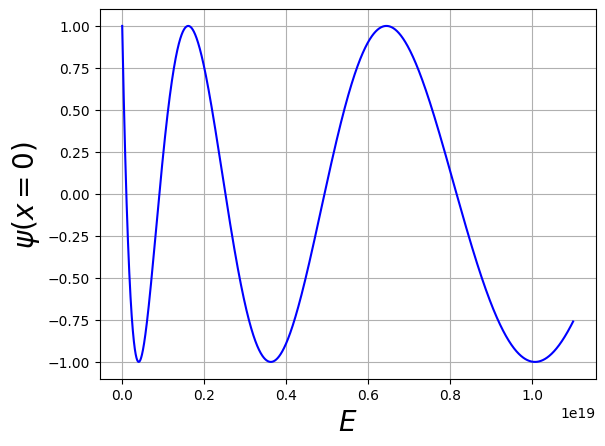

In [112]:
plt.plot(en, psi_b, 'r-', color='blue')
plt.xlabel(r'$E$',size=20)
plt.ylabel(r'$\psi(x=0)$',size=20)
plt.grid(True)
plt.show()

### Question 1

Describe what happens to the plot above if you double the width of the well. 

__Note__: you can return the width of the well to its original value once you're done

### Finding precise solutions

It is a bit hard to read off the exact values of the zeroes on the figure above so we are going to use a python routine called brentq that will find them more precisely. The routine locates two subsequent values in the array psi_b where there is a sign change and then uses extrapolation techniques to find more precise values for the value of E that gives us $\psi(x=0)=0$. 

__ACTION__: Using the fact that sign(y) returns +1 for any positive value and -1 for any negative value, what code could you write for the if statement below in order to pick out the zeroes?

In [100]:
def find_all_zeroes(x,y): #Returns list of values of x for which y(x)=0
    all_zeroes = []
    s = sign(y)
    for i in range(len(y)-1):
        if y[i] <= 0 < (y[i+1]) or y[i+1] <= 0 < y[i]:    # then somewhere between y and y+1, the function is zero
            zero = brentq(Wave_function, x[i], x[i+1])
            all_zeroes.append(zero)
    return all_zeroes

We can now determine all of the zeroes in the range up to $E_{max}$ and print them out

In [101]:
E_zeroes = find_all_zeroes(en, psi_b)   # now find the precise energies where psi(x=0) = 0 
print( "Energies for the bound states are: ")
for E in E_zeroes:
        print( '%11.7f' % E)

Energies for the bound states are: 
 10.3301867
 29.7239682
 59.5459219
 98.8616462


### Question 2

Verify explicitly that the numerical values you find in this exercise correspond to the exact solution from Section 2.2 in Griffiths. It may be helpful to make a table comparing the two sets of energies.

With the precise energy values determined we can look at the wavefunctions. Since in this case we want the wave-function throughout the whole well, we will need to re-define the x-axis to extend from -a to a. We should also normalize the wave-functions.

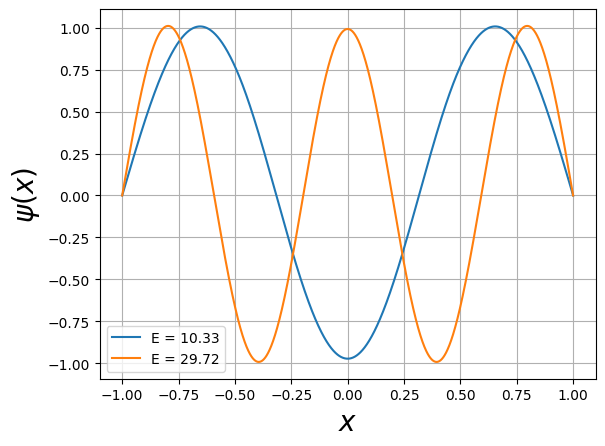

In [102]:
x = linspace(-a, a, N)
h=2*a/(N-1)
for E in E_zeroes[0:2]:
        Wave_function(E)
        psi[:,0]=psi[:,0]/sqrt(h*np.sum(np.square(psi[:,0])))
        plt.plot(x, psi[:,0], label="E = %.2f"%E)


plt.legend(loc='lower left')
plt.xlabel(r'$x$',size=20)
plt.ylabel(r'$\psi(x)$',size=20)
plt.legend()
plt.grid(True)
plt.show()


### Question 3

We find the odd solutions here since Wave_function returns $\psi(0)$. If we instead want to look for solutions where $\psi'(0)=0$ all we have to do is to return psi[-1,1] from Wave_function. Try this and compare the energies to what you find from Griffiths.

### Question 4

The A13 bionic chip released by apple is manufactured by TSMC using their 7 nanometer process. Assume that we can model the properties of this chip using an infinite potential well. 

If the **total** width of the infinite well is 7 nanometers, convert the energies that you have found for both odd and even states into units of electron Volts (eV). Assume that $m$ is the mass of an electron.

### Question 5

Now let's have some fun. While we only solved the infinite square well in class, we can easily use the shooting method to find numerical solutions to many other potentials where we can't determine the analytic solution. However, we still have to stick to symmetric potentials with a hard wall. 

__ACTION__: Modify your potential so that at the center of the well (between -a/2 and a/2) it takes on a value of -2. You will also need to modify the energies that you're looking for by changing Ebottom. 

(a) What are the first 2 energies for even wave-functions? 

(b) Plot the square of the first 2 even wave-functions that you find. Where is the particle most likely to be found in each of the states? Explain.